## Calibration Workshop (Advanced Topics)

Advanced Topics:

Here we will demonstrate a couple of advanced topics:

1) Using the `unity_prior` in `SplineCalib`

2) Using SplineCalib for Multiclass Calibration

## Part 1: The **unity_prior**
Often, when dealing with very small calibration training sets, it is useful to use a "unity" prior distribution.  This means that, before we see any data, we assume that the input distribution is (relatively) well-calibrated, and we put a "weight" (measured in number of observations) on that belief.  It may also be useful when there are very few examples in a particular part of the curve.

In SplineCalib, we control this with the parameters `unity_prior`, `unity_prior_weight`, and `unity_prior_gridsize`.  Setting `unity_prior` to True, will augment the training data with observations along the axis y=x.  `unity_prior_weight` controls the "strength" of the prior, measured in number of observations.  `unity_prior_gridsize` controls the resolution of the augmented points.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, confusion_matrix


import ml_insights as mli

### Making some synthetic data

In [2]:
## This is a (rather ugly) function that allows us 
## to make piecewise linear functions easily

def make_pw_linear_fn(xvals, yvals):
    def lin_func(x):
        if type(x)==np.ndarray:
            return(np.array([lin_func(i) for i in x]))
        
        if x<=xvals[0]:
            return(yvals[0])
        elif x>=xvals[-1]:
            return(yvals[-1])
        else:
            asd=np.max(np.where(x>xv)[0])
            return(yv[asd]+((x-xv[asd])*(yv[asd+1]-yv[asd])/(xv[asd+1]-xv[asd])))
    return lin_func

In [3]:
## If we specify a set of x_values and y values it returns a function 
## that linearly interpolates between them on the domain specified
xv = np.array([0,.1,.4,.7,.9,1])
yv = np.array([0,.4,.7,.8,.95,1])
f1 = make_pw_linear_fn(xv,yv)

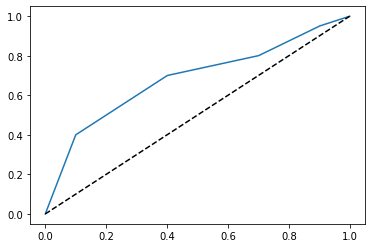

In [4]:
# Here's what the resulting function looks like
# We will use this below to represent the "true" calibration function
# In other words, when x is our model output, f1(x) will be the 
# true probability that y=1 given x
tvec = np.linspace(0,1,1001)
plt.plot(tvec,f1(tvec))
plt.plot(tvec,tvec,'k--')

We generate some synthetic data.

`xvec` representes the uncalibrated scores

`probvec` represents the true probability for that score

`yvec` is the binary outcome based on the true probability

Given xvec and yvec, we wish to recover an estimate of 
the function `f1` that we defined above
which maps scores to true probabilities

In [5]:
np.random.seed(0)
npts = 100
xvec = np.random.uniform(size =npts)
probvec = f1(xvec)
yvec = np.random.binomial(n=1, p=probvec)

In [6]:
xvec_test = np.random.uniform(size=50000)
probvec_test = f1(xvec_test)
yvec_test = np.random.binomial(n=1, p=probvec_test)

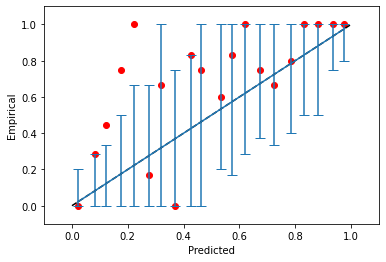

In [7]:
# From this reliability diagram, we see that our scores
# are underpredicting the true probability
mli.plot_reliability_diagram(yvec,xvec);

In [8]:
# We use a SplineCalib with no unity_prior and fit it to the calibration data
sc0 = mli.SplineCalib(unity_prior=False)
sc0.fit(xvec, yvec)

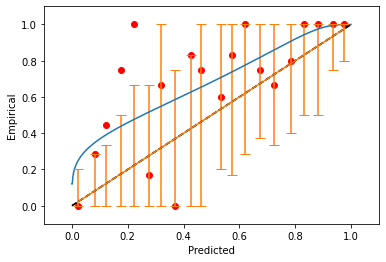

In [9]:
# Here is the calibration curve superimposed on the reliability diagram# We see it fits the data well without being overly wiggly
sc0.show_calibration_curve()
mli.plot_reliability_diagram(yvec,xvec);

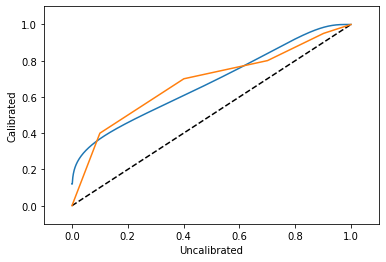

In [10]:
# Here is the calibration curve compared to the "true" answer
# We see it fits well, though it "rounds off" the corners
# This is by design, the splines are required to have a continuous
# first (and second) derivative
sc0.show_calibration_curve()
plt.plot(tvec, f1(tvec))

In [11]:
# Here we see that the log_loss of our calibrated probabilities
# are nearly as good as using the actual "right answer"
# and a large improvement over the uncalibrated probabilities
(log_loss(yvec_test, xvec_test), 
 log_loss(yvec_test, sc0.calibrate(xvec_test)), 
 log_loss(yvec_test, f1(xvec_test)))

(0.6123338280741124, 0.5146800746785191, 0.5005851920857376)

In [12]:
# Take the previous calibration curve and add a unity prior with weight 25
sc1 = mli.SplineCalib(unity_prior=True, 
                      unity_prior_weight=25,
                      max_iter=5000)
sc1.fit(xvec, yvec)

In [13]:
# We get a warning about lack of convergence.  This is usually not a problem, but can
# usually be fixed by increasing the number of iterations via "max_iter"

sc2 = mli.SplineCalib(unity_prior=True,
                      unity_prior_weight=100,
                      max_iter=5000)
sc2.fit(xvec, yvec)

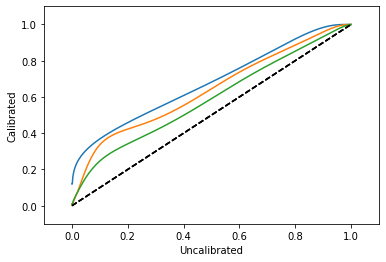

In [14]:
# We see that the curve gets closer to the line y=x as we increase the 
# weight of the unity prior
sc0.show_calibration_curve()
sc1.show_calibration_curve()
sc2.show_calibration_curve()

In [15]:
# Adding unity prior of weight 25 slight improves the test set performance in this case
# Adding unity priot of weight 100 makes it considerably worse
# Recall that our training data was size 100

(log_loss(yvec_test, sc0.calibrate(xvec_test)), 
 log_loss(yvec_test, sc1.calibrate(xvec_test)), 
 log_loss(yvec_test, sc2.calibrate(xvec_test)))

(0.5146800746785191, 0.511615154985576, 0.5308680348557809)

## Multiclass Calibration
- Calibrating a multiclass model is considerably more complex.  
- SplineCalib takes a "One-vs-Rest" approach doing a binary calibration for each class independently.  
- After re-calibrating each class, it re-normalizes the probabilities so that they sum to 1.

### Example: MNIST Random Forest model data

This notebook is to demonstrate how to do multiclass calibration using SplineCalib functionality in the ml_insights package.  We will use PCA to extract components from images, run a random forest model, and then demonstrate how to properly calibrate the predictions from the Random Forest Model.

In [16]:
# try `!pip install keras` if keras not found
# We use keras just to get the mnist data
# You can also download MNIST at yann.lecun.com/exdb/mnist

from keras.datasets import mnist


#### Load the Data, Examine and Explore

In [17]:
## Load in the MNIST data
(trainX, y_train), (testX, y_test) = mnist.load_data()

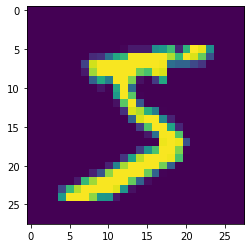

In [18]:
## Here is an example image
plt.imshow(trainX[0])

In [19]:
# let's reshape the data so that the pixel values are 784 distinct columns

X_train = trainX.reshape(60000,28*28)
X_test = testX.reshape(10000,28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [20]:
## Scale the values before doing PCA
s = StandardScaler()
X_train_std = s.fit_transform(X_train)
X_test_std = s.transform(X_test)

In [21]:
## Run a PCA on the standardized values
pca_proc = PCA(n_components=30)
pca_proc.fit(X_train_std)

PCA(n_components=30)

In [22]:
# Transform the data - after this we have 30 PCA features to use in our Random Forest model

X_train_pca = pca_proc.transform(X_train_std)
X_test_pca = pca_proc.transform(X_test_std)
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.columns = ['pca_vec_'+str(j) for j in range(X_train_pca.shape[1])]
X_test_pca = pd.DataFrame(X_test_pca)
X_test_pca.columns = ['pca_vec_'+str(j) for j in range(X_test_pca.shape[1])]


In [23]:
# Train our Random Forest model

rf1 = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf1.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [24]:
# Get the predicted "probabilities" (vote percentages from the RF)
# Also, use the argmax to get the "hard" prediction (most likely digit)

test_probs = rf1.predict_proba(X_test_pca)
hard_preds = np.argmax(test_probs, axis=1)

In [25]:
# Evaluate the model in terms of log_loss and accuracy

log_loss(y_test, test_probs), accuracy_score(y_test, hard_preds)

(0.30512584265056036, 0.9424)

In [26]:
# Generate cross_validated predictions on your training data
# This will be the data your calibration object "learns" from

cv_train_preds = mli.cv_predictions(rf1, X_train_pca, y_train)

In [27]:
# Define the calibration object and fit it to the cross-validated predictions

calib_mc = mli.SplineCalib(unity_prior=False)
calib_mc.fit(cv_train_preds, y_train, verbose=True)

Calibrating Class 0
Calibrating Class 1
Calibrating Class 2
Calibrating Class 3
Calibrating Class 4
Calibrating Class 5
Calibrating Class 6
Calibrating Class 7
Calibrating Class 8
Calibrating Class 9


In [28]:
# Calibrate the previous predictions from the model

test_probs_calibrated = calib_mc.calibrate(test_probs)

In [29]:
# Compare the previous (uncalibrated) log_loss with the calibrated one

log_loss(y_test, test_probs), log_loss(y_test, test_probs_calibrated)

(0.30512584265056036, 0.1797032526747971)

In [30]:
# Make hard predictions based on the calibrated probability values
# In multiclass problems, calibration can often improve accuracy

hard_preds_calib = np.argmax(test_probs_calibrated, axis=1)

In [31]:
# We (sometimes) see an increase in accuracy...

accuracy_score(y_test, hard_preds), accuracy_score(y_test, hard_preds_calib)

(0.9424, 0.9426)

## Assessing the Calibration
SplineCalib (and the ml_insights package) also contains some plots and tools to help you assess the quality of your calibration.  While the default settings generally work fairly well, there are adjustments that can be made.

Below we see the calibration curves plotted on top of the reliability diagrams.  We see that the calibration curves do a good job of fitting the empirical probabilities.  Note also that the calibration curves are noticeably different for different classes.

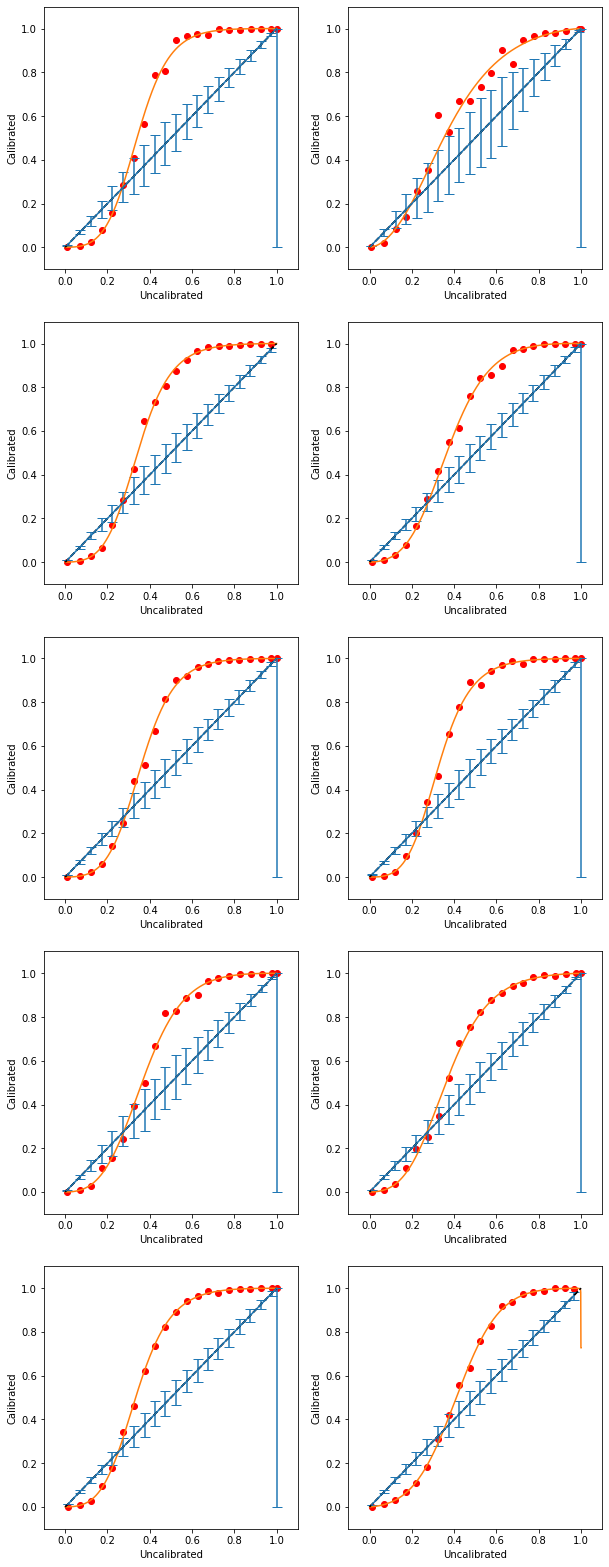

In [32]:
plt.figure(figsize=(10,28))
for i in range(10):
    plt.subplot(5,2,i+1)
    mli.plot_reliability_diagram((y_train==i).astype(int), cv_train_preds[:,i]);
    calib_mc.show_calibration_curve(class_num=i)

### Thanks!

If you are interested in learning more, please check out the tutorials at:
https://github.com/numeristical/introspective/tree/master/examples

(The ones that start with "SplineCalib")